In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
bus_adjacency: BUS_ANY
incarnation: 17707024940352591689
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 347275264
incarnation: 13621273238960714995
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0"
]


In [6]:
%matplotlib inline
from __future__ import print_function, division
path = "data/baidu/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
import cv2
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [7]:
train_path = 'data/baidu/image_contest_level_2_processed/'
label_exp_count = load_array('data/baidu/label_exp_num.data')

In [8]:
label_exp_files = []
for i, cnt in enumerate(label_exp_count):
    for c in range(cnt):
        label_exp_files.append('{}-{}-{}.png'.format(i, cnt-c, cnt))

In [9]:
label_path = 'data/baidu/level2_labels.txt'
raw_label_list = []
with open(label_path) as f:
    raw_label_list = f.readlines()
raw_label_list = [x.strip() for x in raw_label_list]
label_exp_num_length= []
exp_labels = []
exp_lens =[]
for line in raw_label_list:
    parts = line.split(' ')
    exprs = parts[0]
    result = parts[1]
    label_exp_num_length.append(len(exprs.split(';')))
    for exp in exprs.split(';'):
        exp_labels.append(exp.decode('utf8'))
        exp_lens.append(len(exp.decode('utf8')))

In [10]:
short_idxs = []
long_idxs = []
cursor = 0
for cnt in label_exp_count:
    for i in range(cnt):
        if i==cnt-1:
            long_idxs.append(cursor+i)
        else: 
            short_idxs.append(cursor+i)
    cursor = cursor + cnt
short_idxs = np.asarray(short_idxs)
long_idxs = np.asarray(long_idxs)

In [36]:
class DataGenator(keras.callbacks.Callback):
    
    def __init__(self, idxs, width, height):
        self.width = width
        self.height = height
        self.idxs = idxs
        self.label_length = max(np.asarray(exp_lens)[self.idxs])

        mask = np.random.rand(len(self.idxs)) < 0.9
        self.trn_idxs = self.idxs[mask]
        self.val_idxs = self.idxs[~mask]
        
        self.token_counts = {}
        for exp in np.asarray(exp_labels)[self.idxs]:
            for c in exp:
                if c in self.token_counts:
                    self.token_counts[c] += 1
                else:
                    self.token_counts[c] = 1
        self.tokens = sorted(self.token_counts.keys()) + ['N']
        self.zero_idx = len(self.tokens)-1
        
        
        self.token_idxs = dict()
        for i,token in enumerate(self.tokens):
            self.token_idxs[token] = i
            
        #所有的label都转化  但不会全部用上  用不上的为空
        self.actual_labels = np.full((len(exp_labels), self.label_length), self.zero_idx)
        for idx in idxs:
            for i, token in enumerate(exp_labels[idx]):
                self.actual_labels[idx][i] = self.token_idxs[token]
            
    def get_batch(self, batch_size, idxs, shuffle=True):
        if shuffle:  
            idxs = np.random.permutation(idxs)
        cur = 0
        idxs_len = len(idxs)
        while True:
            out = []
            next_cur = cur + batch_size
            if next_cur < idxs_len:
                out = idxs[cur: next_cur]
                cur = next_cur
            else:
                exceed = next_cur - idxs_len
                out = idxs[cur: idxs_len]
                if shuffle:  idxs = np.random.permutation(idxs)
                out = np.concatenate([out, idxs[0: exceed]]) 
                cur = exceed
            yield self.fetch_img_by_idxs(out), np.asarray(self.actual_labels)[out]
        
    def fetch_img_by_idxs(self, idxs):
        imgs = []
        for f in np.array(label_exp_files)[idxs]:
            img = cv2.imread(train_path+f)
            img = cv2.resize(img, (self.width, self.height), interpolation = cv2.INTER_LINEAR)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #img= np.expand_dims(img, axis=-1)
            img = np.transpose(np.asarray(img), (1, 0, 2))
            imgs.append(img)
        return np.array(imgs)
    
    
    def to_pretty_label(self, label):
        l = label.flatten().astype('int')
        s =''
        for token in l:
            if token != self.zero_idx:
                 s = s+self.tokens[token]
        return s    

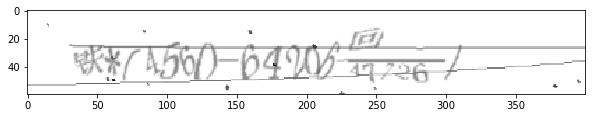

In [26]:
img_gen = DataGenator(idxs=using_idxs, width=img_w, height=img_h)
test_imgs = np.transpose(img_gen.fetch_img_by_idxs([1,2,4,5]), (0, 2, 1, 3)).reshape(-1, 60, 400)

f = plt.figure(figsize=(10,10), frameon=True)
plt.imshow(test_imgs[3])

In [37]:
### 决定使用什么类型的数据
using_idxs = long_idxs
img_label_data_prefix = 'all_long_2_3'
data_path = 'data/baidu/all-long-400-60/'

img_w = 400
img_h = 60

img_gen = DataGenator(idxs=using_idxs, width=img_w, height=img_h)

In [8]:
def save_raw_data():
    da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
    imgs, labels = next(da)
    save_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix),  imgs)
    save_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix), labels)

def load_raw_data():
    imgs = load_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix))
    labels = load_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix))
    return (imgs, labels)
    
def save_split_data(x_trn, y_trn, x_val, y_val):

    save_array(data_path+"x_trn", x_trn)
    save_array(data_path+"y_trn", y_trn)


    save_array(data_path+"x_val", x_val)
    save_array(data_path+"y_val", y_val)

def load_split_data():

    x_trn = load_array(data_path+"x_trn")
    y_trn = load_array(data_path+"y_trn")

    x_val = load_array(data_path+"x_val")
    y_val = load_array(data_path+"y_val")
    
    return (x_trn, y_trn, x_val, y_val)

In [11]:
#save_raw_data()
imgs, labels = load_raw_data()

In [12]:
mask = np.random.rand(len(using_idxs)) < 0.9
idxs = np.random.permutation(len(using_idxs))
trn_idxs = idxs[mask]
val_idxs = idxs[~mask]


#da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
#imgs, labels = next(da)

x_trn = imgs[trn_idxs]
y_trn = labels[trn_idxs]

x_val = imgs[val_idxs]
y_val = labels[val_idxs]

In [9]:
#save_split_data(x_trn, y_trn, x_val, y_val)
x_trn, y_trn, x_val, y_val = load_split_data()

In [10]:
x_trn.shape, y_trn.shape, x_val.shape, y_val.shape

((90059, 600, 90, 3), (90059, 30), (9941, 600, 90, 3), (9941, 30))

In [13]:
def show_data(x, y):  
    for i in range(len(x)):
        print(img_gen.to_pretty_label(y[i]))
        plots(np.expand_dims(x[i], axis=0))

In [14]:
def gen_label_length(labels):
    label_lengths = np.zeros((len(labels), 1))
    for i in range(len(labels)):
        label_lengths[i] = len(np.where(np.array(labels[i]) != img_gen.zero_idx)[0])
    return label_lengths.astype('uint8')

In [15]:
def map2seq(x):
    return K.reshape(K.permute_dimensions(x, (0, 3, 2, 1)), (x.shape[0], x.shape[-1], -1))

In [16]:
def map2seq_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4  # only valid for 4D tensors
    return (shape[0], shape[-1], shape[1]*shape[2])

In [17]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

 zoom_range=0.05, shear_range=0.05, channel_shift_range=20,
                             rotation_range=5, height_shift_range=0.03, width_shift_range=0.03

In [18]:
batch_size = 64
da = image.ImageDataGenerator(zoom_range=0.05, shear_range=0.05,
                              channel_shift_range=20, rotation_range=5, 
                              height_shift_range=0.03, width_shift_range=0.03)
#x_trn_len = len(x_trn)//batch_size*batch_size
#trn_batches = da.flow(x_trn[:x_trn_len], y_trn[:x_trn_len], batch_size=batch_size, shuffle=True)

In [19]:
def trn_gen():
    trn_batches = img_gen.get_batch(batch_size, img_gen.trn_idxs, shuffle=False)
    #减2是因为进入ctc时  已经丢弃了2帧
    input_length = np.zeros([batch_size, 1]) + 91
    while True:
        x, y = next(trn_batches)
        x_tranformed = np.zeros(x.shape)
        for i, img in enumerate(x):            
            x_tranformed[i] = da.random_transform(img)
        label_length = gen_label_length(y)
        y[np.where(y==img_gen.zero_idx)] = 0
        yield [x_tranformed, y, input_length, label_length], np.zeros([batch_size])

In [38]:
val_data_batches = img_gen.get_batch(len(img_gen.val_idxs), img_gen.val_idxs, shuffle=False)
x_val, y_val = next(val_data_batches)
size = len(x_val)
#减2是因为进入ctc时  已经丢弃了2帧
x_val_input_length = np.zeros([size, 1]) + 91
y_val_label_length = gen_label_length(y_val)
def val_data():
    return [x_val, y_val, x_val_input_length, y_val_label_length], np.zeros([size])

In [61]:
batches = trn_gen()
def inspect_trn_data():
    batch = next(batches)[0]
    img = batch[0][0]
    label = batch[1][0]
    il =batch[2][0]
    ll  =batch[3][0]
    print(img.shape)
    plots(np.expand_dims(np.transpose(img, (1,0,2)), axis=0))
    print(label)
    print(img_gen.to_pretty_label(label))
    print(il)
    print(ll)
def inspect_val_data():
    batch = val_data()[0]
    img = batch[0][0]
    label = batch[1][0]
    il =batch[2][0]
    ll  =batch[3][0]
    print(img.shape)
    plots(np.expand_dims(np.transpose(img, (1,0,2)), axis=0))
    print(label)
    print(img_gen.to_pretty_label(label))
    print(il)
    print(ll)

(400, 60, 1)


TypeError: Invalid dimensions for image data

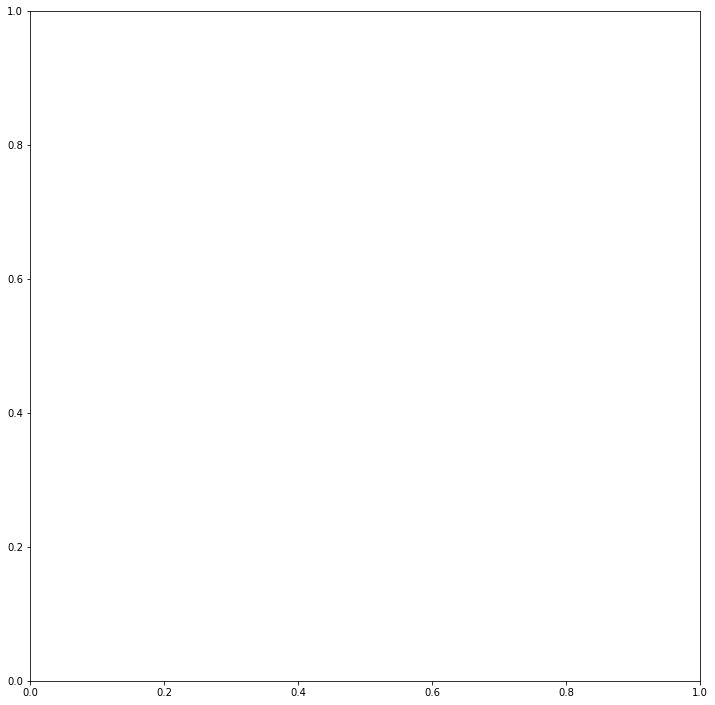

In [18]:
inspect_trn_data()
inspect_val_data()

In [21]:
def is_long_label(label):
    return not(len(np.where(label > 0)[0]) < 10)

In [22]:
def evaluate(base_model, batch_num=None):
    [X_test, y_test, _, label_length], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    pred = base_model.predict(X_test[:batch_num])
    correct_number = 0
    correct_long_n = 0
    total_long_n = 0
    correct_short_n = 0
    total_short_n = 0
    
    shape = pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
    
    for j in range(out.shape[0]):
        
        #-1 是ctc返回的  代表empty
        l = out[j][np.where(out[j] != -1)[0]]
        equal =  label_length[j] == len(l) and np.array_equal(l, y_test[j][:label_length[j][0]])
        
        is_long = is_long_label(y_test[j])
        if is_long:
            total_long_n=total_long_n+1
        else:
            total_short_n=total_short_n+1
        if equal:
            correct_number = correct_number+1
            if is_long:
                correct_long_n=correct_long_n+1
            else:
                correct_short_n=correct_short_n+1
    l = 0
    s = 0
    if total_long_n>0: l=correct_long_n/total_long_n
    if total_short_n>0: s=correct_short_n/total_short_n
    
    return correct_number/batch_num, s, l

In [23]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc, s, l = evaluate(base_model)
        self.accs.append(acc)
        acc = acc *100
        s = s * 100
        l = l * 100
        print(' acc: {}% long: {}% short: {}%'.format(acc, s, l))
        
        if acc > 95:
            model.save_weights('v{}.wgt'.format(epoch))

evaluator = Evaluate()

In [28]:
ctc_time_lenght = 75
input_shape=(img_gen.width, img_gen.height, 3)
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = BatchNormalization()(input_data)

inner = Convolution2D(64, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(64, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
x = MaxPooling2D()(inner)


inner = Convolution2D(128, 3, 3,  activation='relu', border_mode='same')(x)
inner = BatchNormalization()(inner)
inner = Convolution2D(128, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

residual = Convolution2D(128, 1,1, subsample=(2,2))(x)
residual = BatchNormalization()(residual)

x = merge([inner, residual], mode='sum')

inner = Convolution2D(256, 3, 3,  activation='relu', border_mode='same')(x)
inner = BatchNormalization()(inner)
inner = Convolution2D(256, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)
inner = ZeroPadding2D(padding={'left_pad':1})(inner)

residual = Convolution2D(256, 1,1, subsample=(1,2))(x)
residual = BatchNormalization()(residual)

x = merge([inner, residual], mode='sum')

inner = Convolution2D(512, 3, 3,  activation='relu', border_mode='same')(x)
inner = BatchNormalization()(inner)
inner = Convolution2D(512, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)

#inner = Lambda(map2seq, output_shape=map2seq_output_shape)(inner)
inner = Reshape((ctc_time_lenght, -1))(inner)

inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='sum')(inner)
inner = BatchNormalization()(inner)

inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='concat')(inner)
inner = BatchNormalization()(inner)

y_pred = Dense(len(img_gen.tokens), activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(img_gen.label_length,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 300, 45, 3)    0                                            
____________________________________________________________________________________________________
batchnormalization_12 (BatchNorm (None, 300, 45, 3)    12          the_input[0][0]                  
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 300, 45, 64)   1792        batchnormalization_12[0][0]      
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorm (None, 300, 45, 64)   256         convolution2d_11[0][0]           
___________________________________________________________________________________________

In [60]:

input_shape=(img_gen.width, img_gen.height, 3)
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = BatchNormalization()(input_data)

inner = Convolution2D(32, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(32, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(64, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(64, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(128, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(128, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)

inner = Convolution2D(256, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(256, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)


ctc_time_lenght = 93
inner = Reshape((ctc_time_lenght, -1))(inner)

inner = Bidirectional(LSTM(512, return_sequences=True, inner_init='identity'), merge_mode='sum')(inner)
inner = BatchNormalization()(inner)


y_pred = Dense(len(img_gen.tokens), activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(img_gen.label_length,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)
    


model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 400, 60, 3)    0                                            
____________________________________________________________________________________________________
batchnormalization_31 (BatchNorm (None, 400, 60, 3)    12          the_input[0][0]                  
____________________________________________________________________________________________________
convolution2d_25 (Convolution2D) (None, 398, 58, 32)   896         batchnormalization_31[0][0]      
____________________________________________________________________________________________________
batchnormalization_32 (BatchNorm (None, 398, 58, 32)   128         convolution2d_25[0][0]           
___________________________________________________________________________________________

In [54]:
#x_trn_len = ((len(img_gen.trn_idxs)//batch_size)/10) * batch_size
#x_val_len = ((len(img_gen.val_idxs)//batch_size)/10) * batch_size * 2
x_trn_len = len(img_gen.trn_idxs)//batch_size * batch_size
x_val_len = len(img_gen.val_idxs)//batch_size* batch_size

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30,
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
89920/89920 [==============================] - 759s - loss: 20.7802 - val_loss: 2.7994
Epoch 2/30
89920/89920 [==============================] - 753s - loss: 3.8765 - val_loss: 1.6845
Epoch 3/30
89920/89920 [==============================] - 749s - loss: 2.9563 - val_loss: 1.2771
Epoch 4/30
89920/89920 [==============================] - 749s - loss: 2.5330 - val_loss: 1.0986
Epoch 5/30
89920/89920 [==============================] - 749s - loss: 2.2695 - val_loss: 1.0329
Epoch 6/30
89920/89920 [==============================] - 749s - loss: 2.0782 - val_loss: 0.9040
Epoch 7/30
89920/89920 [==============================] - 750s - loss: 1.9071 - val_loss: 0.8084
Epoch 8/30
89920/89920 [==============================] - 750s - loss: 1.8150 - val_loss: 0.7202
Epoch 9/30
89920/89920 [==============================] - 750s - loss: 1.7255 - val_loss: 0.7056
Epoch 10/30
89920/89920 [==============================] - 749s - loss: 1.6340 - val_loss: 0.6677
Epoch 11/30
89920/89920 [===

In [ ]:
evaluator.on_epoch_end(10)
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30,
                    validation_data=val_data(), nb_val_samples=x_val_len)

 acc: 90.9181636727% long: 0% short: 90.9181636727%
Epoch 1/30
89920/89920 [==============================] - 782s - loss: 1.0665 - val_loss: 0.3679
Epoch 2/30
89920/89920 [==============================] - 782s - loss: 1.0346 - val_loss: 0.3809
Epoch 3/30
89920/89920 [==============================] - 780s - loss: 1.0360 - val_loss: 0.3622
Epoch 4/30
89920/89920 [==============================] - 780s - loss: 1.0398 - val_loss: 0.3621
Epoch 5/30
89920/89920 [==============================] - 781s - loss: 1.0138 - val_loss: 0.3172
Epoch 6/30
89920/89920 [==============================] - 780s - loss: 1.0229 - val_loss: 0.3720
Epoch 7/30
89920/89920 [==============================] - 779s - loss: 0.9971 - val_loss: 0.3320
Epoch 8/30
89920/89920 [==============================] - 781s - loss: 1.0020 - val_loss: 0.3469
Epoch 9/30
89920/89920 [==============================] - 781s - loss: 0.9533 - val_loss: 0.3341
Epoch 13/30
89920/89920 [==============================] - 780s - loss: 0.9

In [94]:
evaluator.on_epoch_end(30)

 acc: 92.8842315369% long: 0% short: 92.8842315369%


### 8-cnn-32-256 + 1-512-rnn

In [27]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)

Epoch 1/15
9024/8985 [==============================] - 71s - loss: 90.1488    

/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/15
9024/8985 [==============================] - 68s - loss: 46.0083    
Epoch 3/15
9024/8985 [==============================] - 67s - loss: 27.2347    
Epoch 4/15
9024/8985 [==============================] - 68s - loss: 21.1215    
Epoch 5/15
9024/8985 [==============================] - 72s - loss: 18.2949    
Epoch 6/15
9024/8985 [==============================] - 67s - loss: 14.8492    
Epoch 7/15
9024/8985 [==============================] - 68s - loss: 10.0249    
Epoch 8/15
9024/8985 [==============================] - 67s - loss: 7.9436    
Epoch 9/15
9024/8985 [==============================] - 68s - loss: 6.5874    
Epoch 10/15
9024/8985 [==============================] - 68s - loss: 5.8841    
Epoch 11/15
9024/8985 [==============================] - 79s - loss: 5.2141    
Epoch 12/15
9024/8985 [==============================] - 86s - loss: 4.9485    
Epoch 13/15
9024/8985 [==============================] - 83s - loss: 4.8576    
Epoch 14/15
9024/8985 [==================

In [28]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8985 [==============================] - 87s - loss: 3.9267    
Epoch 2/15
9024/8985 [==============================] - 87s - loss: 3.8514    
Epoch 3/15
9024/8985 [==============================] - 85s - loss: 3.6487    
Epoch 4/15
9024/8985 [==============================] - 85s - loss: 3.4395    
Epoch 5/15
9024/8985 [==============================] - 85s - loss: 3.3201    
Epoch 6/15
9024/8985 [==============================] - 86s - loss: 3.2385    
Epoch 7/15
9024/8985 [==============================] - 85s - loss: 3.2414    
Epoch 8/15
9024/8985 [==============================] - 86s - loss: 3.2149    
Epoch 9/15
9024/8985 [==============================] - 87s - loss: 2.9775    
Epoch 10/15
9024/8985 [==============================] - 85s - loss: 2.9278    
Epoch 11/15
9024/8985 [==============================] - 86s - loss: 2.9239    
Epoch 12/15
9024/8985 [==============================] - 86s - loss: 2.9076    
Epoch 13/15
9024/8985 [==========================

In [30]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8985 [==============================] - 86s - loss: 2.6188    
Epoch 2/15
9024/8985 [==============================] - 85s - loss: 2.6276    
Epoch 3/15
9024/8985 [==============================] - 85s - loss: 2.5952    
Epoch 4/15
9024/8985 [==============================] - 86s - loss: 2.4569    
Epoch 5/15
9024/8985 [==============================] - 84s - loss: 2.4967    
Epoch 6/15
9024/8985 [==============================] - 84s - loss: 2.4359    
Epoch 7/15
9024/8985 [==============================] - 84s - loss: 2.4145    
Epoch 8/15
9024/8985 [==============================] - 82s - loss: 2.4683    
Epoch 9/15
9024/8985 [==============================] - 84s - loss: 2.3633    
Epoch 10/15
9024/8985 [==============================] - 84s - loss: 2.3208    
Epoch 11/15
9024/8985 [==============================] - 84s - loss: 2.2524    
Epoch 12/15
9024/8985 [==============================] - 85s - loss: 2.3088    
Epoch 13/15
9024/8985 [==========================

In [32]:
vx, vy = val_data()
print(model.evaluate(vx, vy))

10085/10085 [==============================] - 27s    
1.01440175172


In [33]:

history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
evaluator.on_epoch_end(30)

10085/10085 [==============================] - 26s    
1.01440175172
Epoch 1/15
9024/8985 [==============================] - 86s - loss: 2.0742    
Epoch 2/15
9024/8985 [==============================] - 85s - loss: 2.1462    
Epoch 3/15
9024/8985 [==============================] - 84s - loss: 2.1073    
Epoch 4/15
9024/8985 [==============================] - 85s - loss: 2.0965    
Epoch 5/15
9024/8985 [==============================] - 85s - loss: 2.0373    
Epoch 6/15
9024/8985 [==============================] - 85s - loss: 2.0386    
Epoch 7/15
9024/8985 [==============================] - 84s - loss: 2.0292    
Epoch 8/15
9024/8985 [==============================] - 85s - loss: 2.1043    
Epoch 9/15
9024/8985 [==============================] - 84s - loss: 2.0165    
Epoch 10/15
9024/8985 [==============================] - 85s - loss: 1.9463    
Epoch 11/15
9024/8985 [==============================] - 85s - loss: 1.9341    
Epoch 12/15
9024/8985 [==============================] - 85s

In [34]:
vx, vy = val_data()
print(model.evaluate(vx, vy))

10080/10085 [============================>.] - ETA: 0s0.699159664802


In [35]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
evaluator.on_epoch_end(30)
vx, vy = val_data()
print(model.evaluate(vx, vy))

Epoch 1/15
9024/8985 [==============================] - 86s - loss: 1.8099    
Epoch 2/15
9024/8985 [==============================] - 85s - loss: 1.8616    
Epoch 3/15
9024/8985 [==============================] - 86s - loss: 1.8405    
Epoch 4/15
9024/8985 [==============================] - 85s - loss: 1.7582    
Epoch 5/15
9024/8985 [==============================] - 84s - loss: 1.8307    
Epoch 6/15
9024/8985 [==============================] - 85s - loss: 1.8303    
Epoch 7/15
9024/8985 [==============================] - 85s - loss: 1.8632    
Epoch 8/15
9024/8985 [==============================] - 84s - loss: 1.7842    
Epoch 9/15
9024/8985 [==============================] - 86s - loss: 1.7935    
Epoch 10/15
9024/8985 [==============================] - 84s - loss: 1.7541    
Epoch 11/15
9024/8985 [==============================] - 84s - loss: 1.7631    
Epoch 12/15
9024/8985 [==============================] - 84s - loss: 1.7030    
Epoch 13/15
9024/8985 [==========================

### 8-cnn-32-256 + 1-512-rnn  3-channel

In [40]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8985 [==============================] - 80s - loss: 97.1160    
Epoch 2/15
9024/8985 [==============================] - 75s - loss: 52.6259    
Epoch 3/15
9024/8985 [==============================] - 76s - loss: 24.3447    
Epoch 4/15
9024/8985 [==============================] - 76s - loss: 14.4506    
Epoch 5/15
9024/8985 [==============================] - 76s - loss: 10.0137    
Epoch 6/15
9024/8985 [==============================] - 76s - loss: 8.0186    
Epoch 7/15
9024/8985 [==============================] - 76s - loss: 6.8855    
Epoch 8/15
9024/8985 [==============================] - 76s - loss: 5.9318    
Epoch 9/15
9024/8985 [==============================] - 76s - loss: 5.2727    
Epoch 10/15
9024/8985 [==============================] - 76s - loss: 4.9081    
Epoch 11/15
9024/8985 [==============================] - 75s - loss: 4.4005    
Epoch 12/15
9024/8985 [==============================] - 75s - loss: 4.3133    
Epoch 13/15
9024/8985 [=====================

In [41]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8985 [==============================] - 78s - loss: 3.3700    
Epoch 2/15
9024/8985 [==============================] - 75s - loss: 3.3249    
Epoch 3/15
9024/8985 [==============================] - 75s - loss: 3.2367    
Epoch 4/15
9024/8985 [==============================] - 75s - loss: 3.0145    
Epoch 5/15
9024/8985 [==============================] - 76s - loss: 2.9201    
Epoch 6/15
9024/8985 [==============================] - 76s - loss: 2.8751    
Epoch 7/15
9024/8985 [==============================] - 76s - loss: 3.0054    
Epoch 8/15
9024/8985 [==============================] - 76s - loss: 2.7649    
Epoch 9/15
9024/8985 [==============================] - 76s - loss: 2.6440    
Epoch 10/15
9024/8985 [==============================] - 77s - loss: 2.6610    
Epoch 11/15
9024/8985 [==============================] - 76s - loss: 2.5483    
Epoch 12/15
9024/8985 [==============================] - 76s - loss: 2.5756    
Epoch 13/15
9024/8985 [==========================

In [42]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8985 [==============================] - 78s - loss: 2.2957    
Epoch 2/15
9024/8985 [==============================] - 76s - loss: 2.2806    
Epoch 3/15
9024/8985 [==============================] - 76s - loss: 2.2443    
Epoch 4/15
9024/8985 [==============================] - 76s - loss: 2.1681    
Epoch 5/15
9024/8985 [==============================] - 76s - loss: 2.1429    
Epoch 6/15
9024/8985 [==============================] - 76s - loss: 2.1524    
Epoch 7/15
9024/8985 [==============================] - 76s - loss: 2.1952    
Epoch 8/15
9024/8985 [==============================] - 76s - loss: 2.0592    
Epoch 9/15
9024/8985 [==============================] - 76s - loss: 2.0375    
Epoch 10/15
9024/8985 [==============================] - 75s - loss: 2.0667    
Epoch 11/15
9024/8985 [==============================] - 76s - loss: 1.9205    
Epoch 12/15
9024/8985 [==============================] - 75s - loss: 1.9873    
Epoch 13/15
9024/8985 [==========================

In [43]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8985 [==============================] - 69s - loss: 1.8182    
Epoch 2/15
9024/8985 [==============================] - 69s - loss: 1.8458    
Epoch 3/15
9024/8985 [==============================] - 68s - loss: 1.8312    
Epoch 4/15
9024/8985 [==============================] - 68s - loss: 1.8137    
Epoch 5/15
9024/8985 [==============================] - 67s - loss: 1.7605    
Epoch 6/15
9024/8985 [==============================] - 68s - loss: 1.7512    
Epoch 7/15
9024/8985 [==============================] - 68s - loss: 1.8026    
Epoch 8/15
9024/8985 [==============================] - 67s - loss: 1.7826    
Epoch 9/15
9024/8985 [==============================] - 68s - loss: 1.6997    
Epoch 10/15
9024/8985 [==============================] - 68s - loss: 1.7407    
Epoch 11/15
9024/8985 [==============================] - 67s - loss: 1.6870    
Epoch 12/15
9024/8985 [==============================] - 68s - loss: 1.6492    
Epoch 13/15
9024/8985 [==========================

In [44]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8985 [==============================] - 69s - loss: 1.5516    
Epoch 2/15
9024/8985 [==============================] - 68s - loss: 1.6255    
Epoch 3/15
9024/8985 [==============================] - 84s - loss: 1.6326    
Epoch 4/15
9024/8985 [==============================] - 85s - loss: 1.4887    
Epoch 5/15
9024/8985 [==============================] - 85s - loss: 1.5734    
Epoch 6/15
9024/8985 [==============================] - 85s - loss: 1.5778    
Epoch 7/15
9024/8985 [==============================] - 85s - loss: 1.5715    
Epoch 8/15
9024/8985 [==============================] - 86s - loss: 1.5794    
Epoch 9/15
9024/8985 [==============================] - 87s - loss: 1.5243    
Epoch 10/15
9024/8985 [==============================] - 85s - loss: 1.5468    
Epoch 11/15
9024/8985 [==============================] - 87s - loss: 1.4467    
Epoch 12/15
9024/8985 [==============================] - 86s - loss: 1.5293    
Epoch 13/15
9024/8985 [==========================

In [45]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8985 [==============================] - 88s - loss: 1.3871    
Epoch 2/15
9024/8985 [==============================] - 85s - loss: 1.4443    
Epoch 3/15
9024/8985 [==============================] - 87s - loss: 1.4486    
Epoch 4/15
9024/8985 [==============================] - 85s - loss: 1.4057    
Epoch 5/15
9024/8985 [==============================] - 80s - loss: 1.3873    
Epoch 6/15
9024/8985 [==============================] - 68s - loss: 1.4381    
Epoch 7/15
9024/8985 [==============================] - 68s - loss: 1.4192    
Epoch 8/15
9024/8985 [==============================] - 68s - loss: 1.4447    
Epoch 9/15
9024/8985 [==============================] - 67s - loss: 1.4132    
Epoch 10/15
9024/8985 [==============================] - 67s - loss: 1.4050    
Epoch 11/15
9024/8985 [==============================] - 68s - loss: 1.3449    
Epoch 12/15
9024/8985 [==============================] - 68s - loss: 1.4049    
Epoch 13/15
9024/8985 [==========================

In [49]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/30
9024/8985 [==============================] - 69s - loss: 1.2941    
Epoch 2/30
9024/8985 [==============================] - 69s - loss: 1.3281    
Epoch 3/30
9024/8985 [==============================] - 78s - loss: 1.3439    
Epoch 4/30
9024/8985 [==============================] - 85s - loss: 1.2068    
Epoch 5/30
9024/8985 [==============================] - 86s - loss: 1.3412    
Epoch 6/30
9024/8985 [==============================] - 85s - loss: 1.3309    
Epoch 7/30
9024/8985 [==============================] - 85s - loss: 1.3249    
Epoch 8/30
9024/8985 [==============================] - 85s - loss: 1.3506    
Epoch 9/30
9024/8985 [==============================] - 85s - loss: 1.2825    
Epoch 10/30
9024/8985 [==============================] - 84s - loss: 1.3234    
Epoch 11/30
9024/8985 [==============================] - 86s - loss: 1.2231    
Epoch 12/30
9024/8985 [==============================] - 84s - loss: 1.2581    
Epoch 13/30
9024/8985 [==========================

KeyboardInterrupt: 

In [50]:
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

9907/9907 [==============================] - 27s    
0.568474260321
 acc: 86.5549611386% long: 0% short: 86.5549611386%


In [51]:
model.save('86tmp.h5')


In [48]:
history1.history

{'loss': [1.3871317839791588,
  1.4442543425458543,
  1.4486046458812469,
  1.4056928665079969,
  1.3873298041363979,
  1.4381454532028091,
  1.4191648047021095,
  1.4447380604473412,
  1.4132443510048778,
  1.4050007864093104,
  1.3448729058529467,
  1.4048882735536454,
  1.3449463070707117,
  1.2811074941716296,
  1.3496763693525435]}

# 8-cnn-32-256 + 1-512-rnn 3-channel full data

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30,
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
90048/90048 [==============================] - 752s - loss: 26.3769 - val_loss: 3.8394
Epoch 2/30
90048/90048 [==============================] - 707s - loss: 3.9504 - val_loss: 2.1651
Epoch 3/30
90048/90048 [==============================] - 706s - loss: 2.7764 - val_loss: 1.2334
Epoch 4/30
90048/90048 [==============================] - 704s - loss: 2.2691 - val_loss: 1.2606
Epoch 5/30
90048/90048 [==============================] - 707s - loss: 1.9794 - val_loss: 1.0364
Epoch 6/30
90048/90048 [==============================] - 850s - loss: 1.7876 - val_loss: 0.7399
Epoch 7/30
90048/90048 [==============================] - 858s - loss: 1.6259 - val_loss: 0.7244
Epoch 8/30
90048/90048 [==============================] - 851s - loss: 1.5333 - val_loss: 0.7364
Epoch 9/30
90048/90048 [==============================] - 872s - loss: 1.4511 - val_loss: 0.6100
Epoch 10/30
90048/90048 [==============================] - 819s - loss: 1.3595 - val_loss: 0.7071
Epoch 11/30
90048/90048 [===

In [ ]:
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30,
                    validation_data=val_data(), nb_val_samples=x_val_len)

9907/9907 [==============================] - 27s    
0.361743472762
 acc: 91.1678611083% long: 0% short: 91.1678611083%
Epoch 1/30
90048/90048 [==============================] - 853s - loss: 0.8299 - val_loss: 0.3534
Epoch 2/30
90048/90048 [==============================] - 849s - loss: 0.8207 - val_loss: 0.3405
Epoch 3/30
90048/90048 [==============================] - 849s - loss: 0.8242 - val_loss: 0.3205
Epoch 4/30
90048/90048 [==============================] - 846s - loss: 0.8033 - val_loss: 0.3515
Epoch 5/30
90048/90048 [==============================] - 846s - loss: 0.7994 - val_loss: 0.3251
Epoch 6/30
90048/90048 [==============================] - 851s - loss: 0.8026 - val_loss: 0.3344
Epoch 7/30
90048/90048 [==============================] - 849s - loss: 0.7779 - val_loss: 0.3315
Epoch 8/30
90048/90048 [==============================] - 848s - loss: 0.7675 - val_loss: 0.3231
Epoch 9/30
90048/90048 [==============================] - 850s - loss: 0.7692 - val_loss: 0.3160
Epoch 1

In [64]:
evaluator.on_epoch_end(30)

 acc: 92.9544766327% long: 0% short: 92.9544766327%


In [72]:
checkpointer = ModelCheckpoint(filepath='v1/weights.hdf5', verbose=1, save_best_only=True)

In [73]:
model.save_weights('92.95.wgt')

In [83]:
model.load_weights('v1/weights.hdf5')

In [78]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=2, mode='min')

In [77]:
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[checkpointer, reduce_lr, EarlyStopping(patience=10)],
                    validation_data=val_data(), nb_val_samples=x_val_len)
evaluator.on_epoch_end(30)

Epoch 1/30
90048/90048 [==============================] - 858s - loss: 0.6935 - val_loss: 0.3001
Epoch 2/30
90048/90048 [==============================] - 852s - loss: 0.7013 - val_loss: 0.2836
Epoch 3/30
90048/90048 [==============================] - 854s - loss: 0.6814 - val_loss: 0.2960
Epoch 4/30
90048/90048 [==============================] - 853s - loss: 0.6682 - val_loss: 0.2732
Epoch 5/30
90048/90048 [==============================] - 854s - loss: 0.6715 - val_loss: 0.2611
Epoch 6/30
90048/90048 [==============================] - 852s - loss: 0.6739 - val_loss: 0.2720
Epoch 7/30
90048/90048 [==============================] - 854s - loss: 0.6776 - val_loss: 0.2952
Epoch 8/30
90048/90048 [==============================] - 855s - loss: 0.6679 - val_loss: 0.2808
Epoch 9/30
90048/90048 [==============================] - 857s - loss: 0.6674 - val_loss: 0.2701
Epoch 10/30
90048/90048 [==============================] - 856s - loss: 0.6597 - val_loss: 0.3064
Epoch 11/30
90048/90048 [====

KeyboardInterrupt: 

In [84]:
evaluator.on_epoch_end(30)

 acc: 93.9739578076% long: 0% short: 93.9739578076%


### two 256 rnn

In [50]:

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=10)

Epoch 1/10
9024/8992 [==============================] - 104s - loss: 92.5853   
Epoch 2/10
9024/8992 [==============================] - 99s - loss: 49.2063    
Epoch 3/10
9024/8992 [==============================] - 100s - loss: 23.3526   
Epoch 4/10
9024/8992 [==============================] - 99s - loss: 13.9416    
Epoch 5/10
9024/8992 [==============================] - 100s - loss: 10.3580   
Epoch 6/10
9024/8992 [==============================] - 100s - loss: 8.3825   
Epoch 7/10
9024/8992 [==============================] - 99s - loss: 7.0532    
Epoch 8/10
9024/8992 [==============================] - 99s - loss: 6.2068    
Epoch 9/10
9024/8992 [==============================] - 99s - loss: 5.5974    
Epoch 10/10
9024/8992 [==============================] - 100s - loss: 5.0745   


In [70]:
model.evaluate(vx, xy)

10020/10020 [==============================] - 22s    


2.1367193345300213

In [72]:
print(model.evaluate(vx, xy))
evaluator.on_epoch_end(10)

10016/10020 [============================>.] - ETA: 0s1.39598255248
 acc: 71.9161676647% long: 0% short: 71.9161676647%


In [74]:
print(model.evaluate(vx, xy))
evaluator.on_epoch_end(10)

10016/10020 [============================>.] - ETA: 0s1.1713622506
 acc: 76.876247505% long: 0% short: 76.876247505%


In [73]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)


Epoch 1/15
9024/8992 [==============================] - 67s - loss: 2.6341    
Epoch 2/15
9024/8992 [==============================] - 66s - loss: 2.7714    
Epoch 3/15
9024/8992 [==============================] - 66s - loss: 2.6891    
Epoch 4/15
9024/8992 [==============================] - 65s - loss: 2.4872    
Epoch 5/15
9024/8992 [==============================] - 66s - loss: 2.5630    
Epoch 6/15
9024/8992 [==============================] - 66s - loss: 2.4936    
Epoch 7/15
9024/8992 [==============================] - 66s - loss: 2.5310    
Epoch 8/15
9024/8992 [==============================] - 66s - loss: 2.5604    
Epoch 9/15
9024/8992 [==============================] - 65s - loss: 2.4137    
Epoch 10/15
9024/8992 [==============================] - 66s - loss: 2.4536    
Epoch 11/15
9024/8992 [==============================] - 66s - loss: 2.2648    
Epoch 12/15
9024/8992 [==============================] - 66s - loss: 2.3858    
Epoch 13/15
9024/8992 [==========================

In [71]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)


Epoch 1/15
9024/8992 [==============================] - 67s - loss: 3.7914    
Epoch 2/15
9024/8992 [==============================] - 66s - loss: 3.7569    
Epoch 3/15
9024/8992 [==============================] - 66s - loss: 3.5893    
Epoch 4/15
9024/8992 [==============================] - 66s - loss: 3.3820    
Epoch 5/15
9024/8992 [==============================] - 66s - loss: 3.3403    
Epoch 6/15
9024/8992 [==============================] - 66s - loss: 3.2328    
Epoch 7/15
9024/8992 [==============================] - 66s - loss: 3.1929    
Epoch 8/15
9024/8992 [==============================] - 66s - loss: 3.1560    
Epoch 9/15
9024/8992 [==============================] - 66s - loss: 3.0409    
Epoch 10/15
9024/8992 [==============================] - 66s - loss: 3.0977    
Epoch 11/15
9024/8992 [==============================] - 66s - loss: 2.9097    
Epoch 12/15
9024/8992 [==============================] - 66s - loss: 2.9937    
Epoch 13/15
9024/8992 [==========================

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, xy = val_data()
print(model.evaluate(vx, xy))
evaluator.on_epoch_end(10)

Epoch 1/15
9024/8992 [==============================] - 71s - loss: 89.9057    
Epoch 2/15
9024/8992 [==============================] - 65s - loss: 31.5552    
Epoch 3/15
9024/8992 [==============================] - 67s - loss: 10.7403    
Epoch 5/15
9024/8992 [==============================] - 66s - loss: 8.6932    
Epoch 6/15
9024/8992 [==============================] - 66s - loss: 7.3043    
Epoch 7/15
9024/8992 [==============================] - 66s - loss: 6.3577    
Epoch 8/15
9024/8992 [==============================] - 66s - loss: 5.8425    
Epoch 9/15
9024/8992 [==============================] - 66s - loss: 5.3079    
Epoch 10/15
9024/8992 [==============================] - 67s - loss: 5.0625    
Epoch 11/15
9024/8992 [==============================] - 66s - loss: 4.6533    
Epoch 12/15
9024/8992 [==============================] - 66s - loss: 4.4005    
Epoch 13/15
9024/8992 [==============================] - 66s - loss: 4.3810    
Epoch 14/15
9024/8992 [======================

In [88]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, xy = val_data()
print(model.evaluate(vx, xy))
evaluator.on_epoch_end(10)

Epoch 1/15
9024/8992 [==============================] - 74s - loss: 90.3509    
Epoch 2/15
9024/8992 [==============================] - 69s - loss: 46.0820    
Epoch 3/15
9024/8992 [==============================] - 69s - loss: 21.4697    
Epoch 4/15
9024/8992 [==============================] - 70s - loss: 14.2570    
Epoch 5/15
9024/8992 [==============================] - 69s - loss: 10.8184    
Epoch 6/15
9024/8992 [==============================] - 69s - loss: 8.8233    
Epoch 7/15
9024/8992 [==============================] - 69s - loss: 7.7019    
Epoch 8/15
9024/8992 [==============================] - 69s - loss: 6.8158    
Epoch 9/15
9024/8992 [==============================] - 68s - loss: 6.2549    
Epoch 10/15
9024/8992 [==============================] - 69s - loss: 5.7015    
Epoch 11/15
9024/8992 [==============================] - 69s - loss: 5.3110    
Epoch 12/15
9024/8992 [==============================] - 69s - loss: 5.3094    
Epoch 13/15
9024/8992 [=====================

### single 512 rnn

In [58]:

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, xy = val_data()
model.evaluate(vx, xy)

Epoch 1/15
9024/8992 [==============================] - 72s - loss: 94.5323    
Epoch 2/15
9024/8992 [==============================] - 67s - loss: 50.8102    
Epoch 3/15
9024/8992 [==============================] - 67s - loss: 23.5489    
Epoch 4/15
9024/8992 [==============================] - 68s - loss: 13.7862    
Epoch 5/15
9024/8992 [==============================] - 67s - loss: 9.9866    
Epoch 6/15
9024/8992 [==============================] - 67s - loss: 8.0732    
Epoch 7/15
9024/8992 [==============================] - 68s - loss: 6.7811    
Epoch 8/15
9024/8992 [==============================] - 67s - loss: 5.9955    
Epoch 9/15
9024/8992 [==============================] - 68s - loss: 5.4649    
Epoch 10/15
9024/8992 [==============================] - 67s - loss: 5.0845    
Epoch 11/15
9024/8992 [==============================] - 68s - loss: 4.6171    
Epoch 12/15
9024/8992 [==============================] - 67s - loss: 4.4293    
Epoch 13/15
9024/8992 [======================

2.0100703792895622

In [59]:
evaluator.on_epoch_end(10)

 acc: 59.8103792415% long: 0% short: 59.8103792415%


# single 256 rnn


In [34]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=4)



Epoch 1/4
9024/8992 [==============================] - 70s - loss: 86.9000    
Epoch 2/4
9024/8992 [==============================] - 67s - loss: 44.0234    
Epoch 3/4
9024/8992 [==============================] - 66s - loss: 21.6733    
Epoch 4/4
10020/10020 [==============================] - 24s    


8.211456847809508

In [35]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=4)

Epoch 1/4
9024/8992 [==============================] - 70s - loss: 11.1183    
Epoch 2/4
9024/8992 [==============================] - 67s - loss: 8.7139    
Epoch 3/4
9024/8992 [==============================] - 67s - loss: 7.4312    
Epoch 4/4
9024/8992 [==============================] - 66s - loss: 6.4387    


In [37]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=4)

Epoch 1/4
9024/8992 [==============================] - 68s - loss: 5.8657    
Epoch 2/4
9024/8992 [==============================] - 67s - loss: 5.5964    
Epoch 3/4
9024/8992 [==============================] - 67s - loss: 5.1992    
Epoch 4/4
9024/8992 [==============================] - 67s - loss: 4.6448    


In [39]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=4)

Epoch 1/4
9024/8992 [==============================] - 68s - loss: 4.3601    
Epoch 2/4
9024/8992 [==============================] - 67s - loss: 4.2679    
Epoch 3/4
9024/8992 [==============================] - 67s - loss: 4.0454    
Epoch 4/4
9024/8992 [==============================] - 66s - loss: 3.8637    


In [40]:
vx, xy = val_data()
model.evaluate(vx, xy)

10020/10020 [==============================] - 24s    


2.4675790379861158

In [41]:
evaluator.on_epoch_end(10)

 acc: 52.8542914172% long: 0% short: 52.8542914172%


In [21]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30,
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
8960/8992 [============================>.] - ETA: 0s - loss: 97.9486

/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


9024/8992 [==============================] - 162s - loss: 97.7789 - val_loss: 100.2675
Epoch 2/30
9024/8992 [==============================] - 157s - loss: 57.7083 - val_loss: 50.3655
Epoch 3/30
9024/8992 [==============================] - 157s - loss: 34.5343 - val_loss: 25.3586
Epoch 4/30
1984/8992 [=====>........................] - ETA: 95s - loss: 24.3038

KeyboardInterrupt: 

In [109]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30,
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
9024/9011 [==============================] - 193s - loss: 93.8059 - val_loss: 121.8682
Epoch 2/30
9024/9011 [==============================] - 186s - loss: 55.4666 - val_loss: 55.5006
Epoch 3/30
9024/9011 [==============================] - 186s - loss: 28.7007 - val_loss: 23.3613
Epoch 4/30
9024/9011 [==============================] - 187s - loss: 16.1600 - val_loss: 11.1086
Epoch 5/30
9024/9011 [==============================] - 187s - loss: 11.4267 - val_loss: 8.8418
Epoch 6/30
9024/9011 [==============================] - 187s - loss: 8.9788 - val_loss: 5.8765
Epoch 7/30
9024/9011 [==============================] - 187s - loss: 7.5568 - val_loss: 5.2343
Epoch 8/30
9024/9011 [==============================] - 187s - loss: 6.6458 - val_loss: 4.4940
Epoch 9/30
9024/9011 [==============================] - 188s - loss: 5.9083 - val_loss: 8.0724
Epoch 10/30
9024/9011 [==============================] - 187s - loss: 5.4093 - val_loss: 3.4098
Epoch 11/30
9024/9011 [================

In [64]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
89984/89984 [==============================] - 784s - loss: 60.4604 - val_loss: 35.9978
Epoch 2/30
89984/89984 [==============================] - 779s - loss: 11.7352 - val_loss: 3.7134
Epoch 3/30
89984/89984 [==============================] - 781s - loss: 5.0956 - val_loss: 3.2039
Epoch 4/30
89984/89984 [==============================] - 780s - loss: 3.5221 - val_loss: 1.6335
Epoch 5/30
89984/89984 [==============================] - 778s - loss: 2.8496 - val_loss: 1.2290
Epoch 6/30
89984/89984 [==============================] - 779s - loss: 2.4471 - val_loss: 1.2697
Epoch 7/30
89984/89984 [==============================] - 778s - loss: 2.1788 - val_loss: 0.8673
Epoch 8/30
89984/89984 [==============================] - 781s - loss: 1.9713 - val_loss: 0.8966
Epoch 9/30
89984/89984 [==============================] - 779s - loss: 1.8470 - val_loss: 0.7030
Epoch 10/30
89984/89984 [==============================] - 780s - loss: 1.7064 - val_loss: 0.7733
Epoch 11/30
89984/89984 [=

In [65]:
model.optimizer.lr = 0.0001
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
89984/89984 [==============================] - 854s - loss: 0.9307 - val_loss: 0.3982
Epoch 2/30
89984/89984 [==============================] - 849s - loss: 0.9010 - val_loss: 0.3079
Epoch 3/30
89984/89984 [==============================] - 851s - loss: 0.9063 - val_loss: 0.3064
Epoch 4/30
89984/89984 [==============================] - 852s - loss: 0.8896 - val_loss: 0.3362
Epoch 5/30
14720/89984 [===>..........................] - ETA: 656s - loss: 0.9058

KeyboardInterrupt: 

In [63]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=1, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/1
89856/89920 [============================>.] - ETA: 0s - loss: 1.7546 acc: 62.771902%
 short: 0.000000%
 l: 62.771902%
89920/89920 [==============================] - 928s - loss: 1.7543 - val_loss: 1.7435


In [101]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)


Epoch 1/20
89920/89984 [============================>.] - ETA: 0s - loss: 13.4784 acc: 55.311905%
 short: 0.000000%
 l: 55.311905%
89984/89984 [==============================] - 1140s - loss: 13.4700 - val_loss: 2.0453
Epoch 2/20
89920/89984 [============================>.] - ETA: 0s - loss: 1.2172 acc: 68.509062%
 short: 0.000000%
 l: 68.509062%
89984/89984 [==============================] - 1127s - loss: 1.2171 - val_loss: 1.3251
Epoch 3/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.7752 acc: 80.744968%
 short: 0.000000%
 l: 80.744968%
89984/89984 [==============================] - 1138s - loss: 0.7752 - val_loss: 0.7840
Epoch 4/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.5837[ 0 13  6 13 11 14  2 13 10  7 14 13  1  2  0 19  5 15 13  8  9 15  3 10 11  6 15 10 11  1  1]
 acc: 80.915190%
 short: 0.000000%
 l: 80.915190%
89984/89984 [==============================] - 1128s - loss: 0.5837 - val_loss: 0.7762
Epoch 5/20
89920/89984 [===========

KeyboardInterrupt: 

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

model.optimizer.lr=0.0001
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
89920/89984 [============================>.] - ETA: 0s - loss: 13.9007 acc: 72.233904%
 short: 0.000000%
 l: 72.233904%
89984/89984 [==============================] - 1102s - loss: 13.8911 - val_loss: 1.1992
Epoch 2/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.6437 acc: 87.513768%
 short: 0.000000%
 l: 87.513768%
89984/89984 [==============================] - 1092s - loss: 0.6434 - val_loss: 0.5349
Epoch 3/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.3808 acc: 89.696606%
 short: 0.000000%
 l: 89.696606%
89984/89984 [==============================] - 1094s - loss: 0.3807 - val_loss: 0.4391
Epoch 4/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.2809 acc: 91.989586%
 short: 0.000000%
 l: 91.989586%
89984/89984 [==============================] - 1092s - loss: 0.2809 - val_loss: 0.3645
Epoch 5/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.2190 acc: 89.015720%
 short: 0.000000%
 l: 89.015720%


KeyboardInterrupt: 

In [85]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')

plt.show()


KeyError: 'val_loss'

In [ ]:
model.optimizer.lr=0.00001
history3 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.5804[ 0 39  5 13 13  7 12  9  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0 14 10 13 15  8  2  0  0 10  8 14  9 14  4 39  5 11  9  6  8  6  1  1  4  1 14  9 10 10  1]
 acc: 69.959228%
 short: 91.786268%
 l: 33.765363%
215552/215552 [==============================] - 824s - loss: 2.5802 - val_loss: 1.9581
Epoch 2/20
215488/215552 [============================>.] - ETA: 0s - loss: 3.6731[ 0 19  5 13 13  7 12 15  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0  9 11 10 13  8  2  7 15 14  7 15  1  4  0  9 13 14 14 13  1  2 25  5 13  7 10  6 13 15  1]
[ 0  9  7  7 12  6  6  3  0 27  5 13  7  6  6 12  2 11  6  7 14  6  1  1  4 12 10  7 13  8  1]
 acc: 71.535455%
 short: 90.802507%
 l: 39.586592%
215552/215552 [==============================] - 825s - loss: 3.6725 - val_loss: 1.6757
Epoch 3/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.2219 

KeyboardInterrupt: 

In [26]:
def show_result(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        
        print(img_gen.to_pretty_label(l))
        plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
    

In [67]:
def show_wrong_result(base_model, batch_num=None):
    [X_test, y_test, _, label_length], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    pred = base_model.predict(X_test[:batch_num])
    correct_number = 0
    
    shape = pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
    
    for j in range(out.shape[0]):
        l = out[j][np.where(out[j] != -1)[0]]
        
        if label_length[j] != len(l) or not np.array_equal(l, y_test[j][:label_length[j][0]]):
            print(u'{}  {}'.format(img_gen.to_pretty_label(l), img_gen.to_pretty_label(y_test[j])))
            plt.figure(figsize=(10,60), frameon=True)
            plt.imshow(X_test[j].transpose(1,0,2).reshape(60,400,3))
            #plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
            
    

柳=29839
柳=6075
91656+(82642-(回/46950+8842))
锁=67574
塘*(复/85814-77494-43109)
柳-(65454*(奔/26836-7834))
水=22871
锁=35473
深=44448
((81984+27327)-烧)*奔/43062


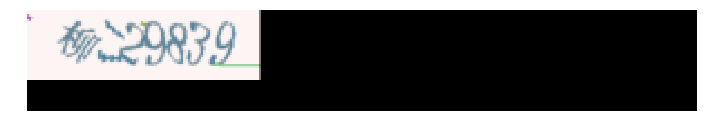

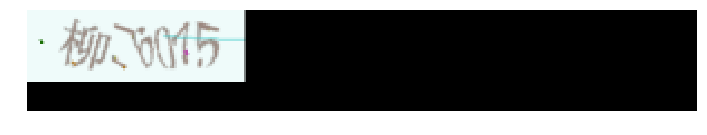

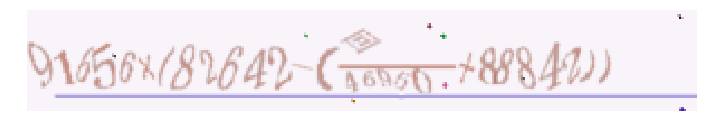

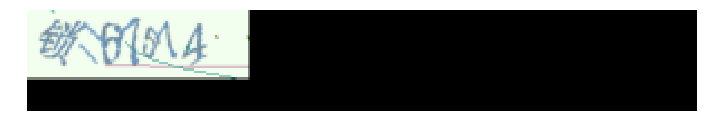

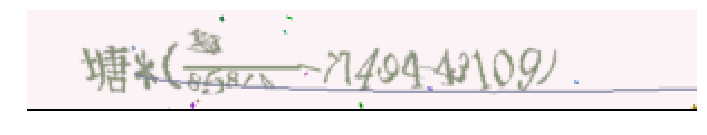

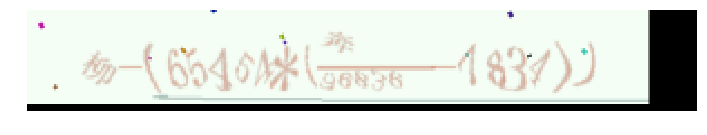

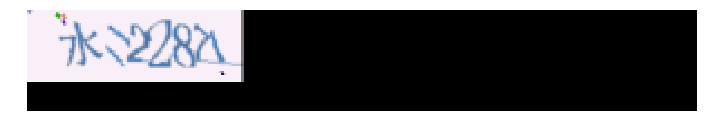

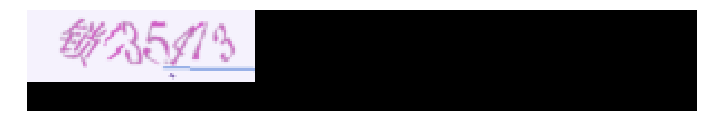

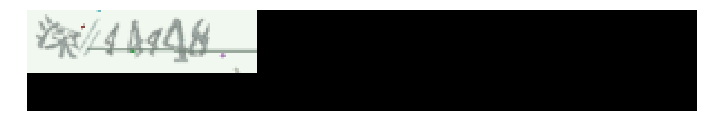

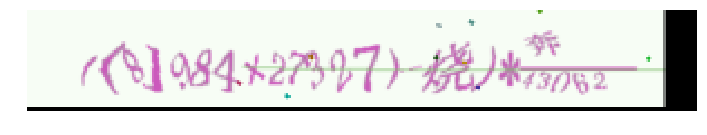

In [70]:
show_result(base_model, 10)

((河/57749*圳)+19133)*69954  ((河/67749*圳)+19133)*69954
海/43307-(87100+71129)-19331  流/43307-(87100+71129)-19331
((锁+之/28815)*66484)+22851  ((锁+之/28615)*66484)+22851
君/92770-99898+塘-43138  河/92770-99898+塘-43138
见/1695*35014+(25010*柳)  见/41695*35014+(25010*柳)


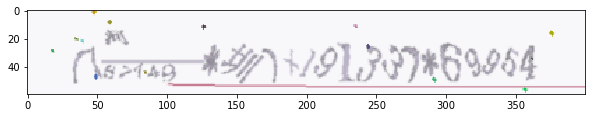

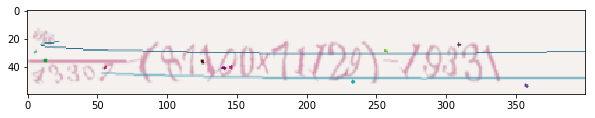

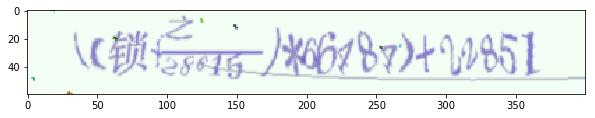

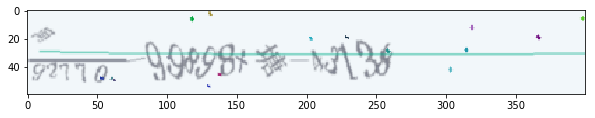

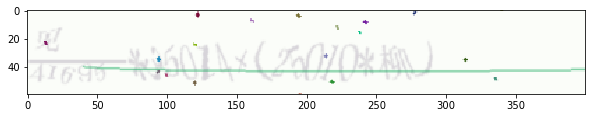

In [86]:
show_wrong_result(base_model, 100)

In [61]:
model.save_weights('l2_first_54.wgt')

In [92]:
model.load_weights('l2_first_54.wgt')

In [95]:
model.save('l2_first_54.h5')

In [59]:
model.save_weights('xxx.wgt')

In [22]:
model.load_weights('xxx.wgt')

In [ ]:
model